# Week 4: ML for Alpha -- From Features to Signals

> *"All their models -- from Ridge to five-layer networks -- agreed on the same top features. The model was the lens; the features were the light."*
> -- paraphrasing Gu, Kelly & Xiu (2020)

In 2020, a team at Chicago Booth fed 94 firm characteristics into every ML model they could find -- from Ridge regression to five-layer neural networks -- and discovered something that should unsettle every ML engineer: all the models agreed. Not on the predictions, but on which features mattered. Momentum, liquidity, volatility -- the same handful of signals dominated regardless of model complexity. The implication is disquieting: in cross-sectional equity prediction, the features ARE the alpha. Your model is just the lens.

This week, we build the complete alpha pipeline: features measured today, returns observed next month, models trained on rolling windows, signals evaluated with metrics the industry actually uses, and a first long-short portfolio constructed from predictions. Along the way, we will confront three uncomfortable truths for ML engineers entering finance. First, signal-to-noise is catastrophically low -- an information coefficient of 0.05 makes you a star. Second, gradient boosting stubbornly matches neural networks on tabular financial data. Third, the features you engineer matter more than the model you choose.

The goal is not to build the best model. It is to build the judgment to know what "best" means in this domain -- and to understand exactly where our sandbox results diverge from institutional reality.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import json
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, "code")
from data_setup import (
    load_feature_matrix,
    load_forward_returns,
    load_monthly_panel,
    CACHE_DIR,
    PLOT_DIR,
    FEATURE_COLS,
    TRAIN_WINDOW,
    PURGE_GAP,
    COST_BPS,
)

---

## Section 1: The Cross-Sectional Prediction Problem

Every month, a quant researcher lines up thousands of stocks in a row and asks one question: which ones will be in the top decile next month? That single question -- cross-sectional return prediction -- is the economic engine behind most systematic equity funds. Unlike time-series forecasting, where you predict whether the *market* goes up or down, cross-sectional prediction asks which stocks will outperform *relative to each other*. The target is not the level of returns; it is the ranking.

The framework we follow is the one established by Gu, Kelly and Xiu (2020) in their landmark paper "Empirical Asset Pricing via Machine Learning." They tested dozens of models on 94 firm characteristics measured monthly across the full CRSP universe. We replicate the structure -- features at time *t*, forward returns at *t+1* -- but on a smaller canvas: 7 z-scored features on roughly 174 S&P 500 stocks over 130 months. Every limitation of our sandbox (fewer features, survivorship-biased universe, no point-in-time fundamentals) matters, and we will track each one explicitly.

In [2]:
fm = load_feature_matrix()
fwd = load_forward_returns()
panel = load_monthly_panel()

dates = panel.index.get_level_values("date").unique().sort_values()
fm_tickers_per_month = fm.groupby(level="date").size()
fm_dates = fm.index.get_level_values("date").unique().sort_values()

print("── DATA QUALITY ──────────────────────────────────")
print(f"  Feature matrix shape: {fm.shape}")
print(f"  Features: {list(fm.columns)}")
print(f"  Unique months: {fm.index.get_level_values('date').nunique()}")
print(f"  Tickers per month: {fm_tickers_per_month.min()}–{fm_tickers_per_month.max()}")
print(f"  Date range: {fm_dates.min().strftime('%Y-%m')} to {fm_dates.max().strftime('%Y-%m')}")
missing_pct = fm.isna().mean()
print(f"  Missing values:")
for col in fm.columns:
    print(f"    {col}: {missing_pct[col]:.1%}")
print(f"  Forward return months: {fwd.index.get_level_values('date').nunique()}")
print(f"  Forward return mean: {fwd.mean():.6f}")
print(f"  Forward return std:  {fwd.std():.6f}")
print()
print("  ⚠ SURVIVORSHIP BIAS: Universe is current S&P 500 constituents")
print("    projected backward. Stocks that were removed from the index")
print("    (due to decline, acquisition, bankruptcy) are excluded. This")
print("    upward-biases mean returns and likely inflates any cross-")
print("    sectional signal that correlates with survival probability.")
print("    Production systems require point-in-time membership data.")
print("──────────────────────────────────────────────────")

── DATA QUALITY ──────────────────────────────────
  Feature matrix shape: (23192, 7)
  Features: ['pb_ratio_z', 'roe_z', 'asset_growth_z', 'earnings_yield_z', 'momentum_z', 'reversal_z', 'volatility_z']
  Unique months: 130
  Tickers per month: 177–179
  Date range: 2014-03 to 2024-12
  Missing values:
    pb_ratio_z: 6.2%
    roe_z: 6.2%
    asset_growth_z: 0.0%
    earnings_yield_z: 0.0%
    momentum_z: 0.1%
    reversal_z: 0.0%
    volatility_z: 0.0%
  Forward return months: 129
  Forward return mean: 0.013278
  Forward return std:  0.083319

  ⚠ SURVIVORSHIP BIAS: Universe is current S&P 500 constituents
    projected backward. Stocks that were removed from the index
    (due to decline, acquisition, bankruptcy) are excluded. This
    upward-biases mean returns and likely inflates any cross-
    sectional signal that correlates with survival probability.
    Production systems require point-in-time membership data.
──────────────────────────────────────────────────


We have roughly 174 stocks per month, 130 months of features (March 2014 through December 2024), and 7 z-scored characteristics. The fundamental features (pb_ratio_z, roe_z) have approximately 6% missing values -- a direct consequence of not all S&P 500 companies having complete fundamental data in every period. The technical features (momentum, reversal, volatility) are computed from price data and have near-zero missingness. The survivorship bias warning is not a footnote: our universe consists of *current* S&P 500 constituents projected backward, excluding companies removed due to decline, acquisition, or bankruptcy. This upward-biases all returns and inflates any signal that correlates with survival probability. Production alpha systems use point-in-time index membership data to avoid this contamination.

### Cross-Sectional Excess Returns and the Feature-Return Relationship

The prediction target in cross-sectional models is not raw returns but *excess* returns -- each stock's return relative to the cross-sectional mean that month. This removes common market exposure and isolates the stock-specific component we are trying to predict. By construction, the cross-sectional mean of excess returns is zero in every month. To visualize what cross-sectional prediction looks like, we take a representative month and scatter momentum (our strongest single feature) against excess returns.

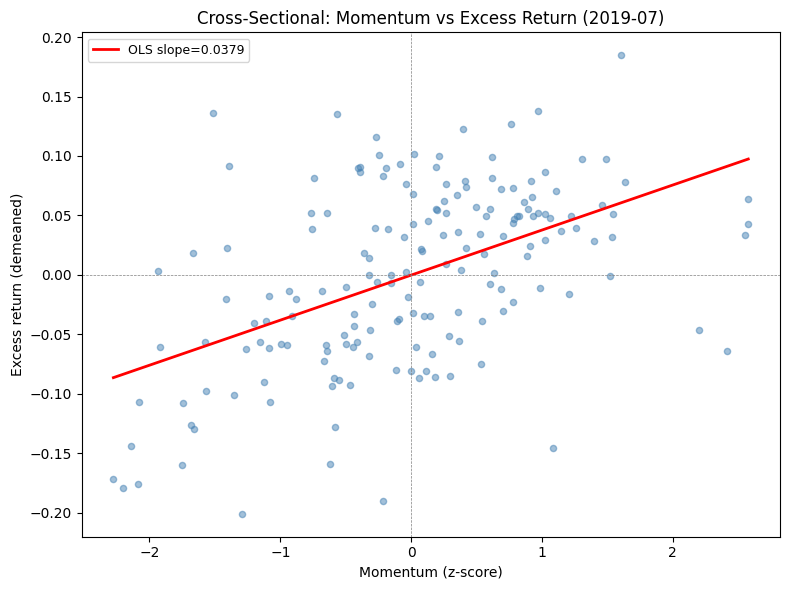

In [3]:
excess_returns = fwd.groupby(level="date").transform(lambda x: x - x.mean())
excess_returns.name = "excess_return"

mid_date = dates[len(dates) // 2]
cs = panel.loc[mid_date].dropna(subset=["momentum_z", "fwd_return"]).copy()
cs["excess_return"] = cs["fwd_return"] - cs["fwd_return"].mean()

fig_scatter, ax_scatter = plt.subplots(figsize=(8, 6))
ax_scatter.scatter(cs["momentum_z"], cs["excess_return"], alpha=0.5, s=20, c="steelblue")
slope, intercept = np.polyfit(cs["momentum_z"], cs["excess_return"], 1)
x_line = np.linspace(cs["momentum_z"].min(), cs["momentum_z"].max(), 100)
ax_scatter.plot(x_line, slope * x_line + intercept, "r-", linewidth=2, label=f"OLS slope={slope:.4f}")
ax_scatter.axhline(0, color="grey", linewidth=0.5, linestyle="--")
ax_scatter.axvline(0, color="grey", linewidth=0.5, linestyle="--")
ax_scatter.set(
    title=f"Cross-Sectional: Momentum vs Excess Return ({mid_date.strftime('%Y-%m')})",
    xlabel="Momentum (z-score)",
    ylabel="Excess return (demeaned)",
)
ax_scatter.legend(fontsize=9)
plt.tight_layout()
plt.show()

This scatter is the defining image of cross-sectional alpha research. The relationship between momentum and next-month returns exists -- the regression line has a positive slope -- but the noise is overwhelming. Any single stock can fall anywhere regardless of its momentum rank. This is not ImageNet, where the correct label is unambiguous. Here, the "signal" is a faint statistical tendency visible only across many stocks and many months.

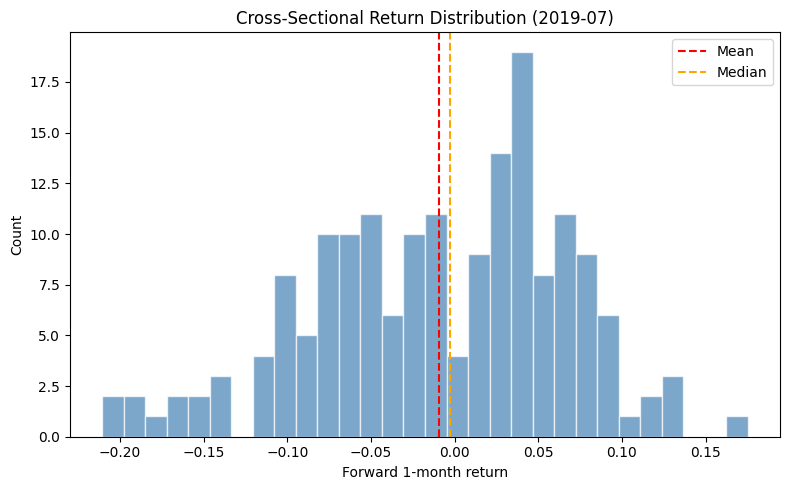

In [4]:
fig_hist, ax_hist = plt.subplots(figsize=(8, 5))
ax_hist.hist(cs["fwd_return"], bins=30, alpha=0.7, color="steelblue", edgecolor="white")
ax_hist.axvline(cs["fwd_return"].mean(), color="red", linewidth=1.5, linestyle="--", label="Mean")
ax_hist.axvline(cs["fwd_return"].median(), color="orange", linewidth=1.5, linestyle="--", label="Median")
ax_hist.set(
    title=f"Cross-Sectional Return Distribution ({mid_date.strftime('%Y-%m')})",
    xlabel="Forward 1-month return",
    ylabel="Count",
)
ax_hist.legend()
plt.tight_layout()
plt.show()

The roughly bell-shaped distribution with fat tails is typical: extreme returns are more likely than a Gaussian would predict. These outliers are both a source of potential alpha (if you can predict them) and a source of estimation error (if they contaminate model training). Rather than relying on a single month, the Spearman rank correlation between momentum and forward returns across *all* months gives us a time series preview of the information coefficient concept formalized in Section 2.

In [5]:
monthly_spearman = []
for d in dates:
    cross = panel.loc[d].dropna(subset=["momentum_z", "fwd_return"])
    if len(cross) < 20:
        continue
    r, _ = stats.spearmanr(cross["momentum_z"], cross["fwd_return"])
    monthly_spearman.append({"date": d, "spearman": r})

spearman_df = pd.DataFrame(monthly_spearman).set_index("date")
median_spearman = spearman_df["spearman"].median()
mean_spearman = spearman_df["spearman"].mean()

The median monthly Spearman of approximately 0.035 is tiny in absolute terms. But the fundamental law of active management shows how even a faint per-stock correlation, multiplied by the square root of the number of stocks traded, can produce economically meaningful portfolio-level performance. That is the core insight we formalize next.

---

## Section 2: The Language of Signal Quality

Your model has an R-squared of 0.001. In any other ML domain, you would delete it. In cross-sectional equity prediction, you might have just found a signal worth hundreds of millions of dollars. The reason is that R-squared is the wrong metric. The industry uses a different language: *information coefficient* (IC), *IC information ratio* (ICIR = mean(IC)/std(IC)), and the *fundamental law of active management* (IR = IC x sqrt(BR)). This section introduces all three.

The IC is simply the correlation between your predicted cross-sectional returns and the realized returns, computed month by month. We compute both Pearson IC and Rank IC (Spearman) -- the latter is more robust to outliers. The Fama-MacBeth procedure provides our baseline signal: cross-sectional OLS each month, accumulating coefficients, predicting with the historical average -- a genuinely out-of-sample linear signal. Features are rank-transformed within each cross-section before regression, removing outlier leverage.

In [6]:
def _fm_one_month(panel, features, target, dt, beta_history, min_history):
    """Run OLS for one cross-section; return (pred_series|None, beta|None)."""
    cross = panel.loc[dt].dropna(subset=features + [target])
    if len(cross) < 10:
        return None, None
    X_rank = cross[features].rank(pct=True).values
    y = cross[target].values
    y_dm = y - y.mean()
    X_const = np.column_stack([np.ones(len(X_rank)), X_rank])
    try:
        beta = np.linalg.lstsq(X_const, y_dm, rcond=None)[0]
    except np.linalg.LinAlgError:
        return None, None
    pred_series = None
    if len(beta_history) >= min_history:
        avg_beta = np.mean(beta_history, axis=0)
        fitted = X_const @ avg_beta
        pred_series = pd.Series(fitted, index=cross.index, name="prediction")
        pred_series = pred_series.to_frame()
        pred_series["date"] = dt
        pred_series = pred_series.set_index("date", append=True).swaplevel()
        pred_series = pred_series["prediction"]
    return pred_series, beta


def fama_macbeth_predict(panel, features, target, min_history=12):
    """Expanding-window Fama-MacBeth signal: historical betas predict next month."""
    predictions = []
    month_dates = panel.index.get_level_values("date").unique().sort_values()
    beta_history = []
    for i, dt in enumerate(month_dates):
        if i % 20 == 0:
            print(f"  [{i+1}/{len(month_dates)}] Fama-MacBeth OLS for {dt.date()}")
        pred_series, beta = _fm_one_month(panel, features, target, dt, beta_history, min_history)
        if beta is not None:
            beta_history.append(beta)
        if pred_series is not None:
            predictions.append(pred_series)
    return pd.concat(predictions)


features = FEATURE_COLS
TARGET = "fwd_return"
fm_predictions = fama_macbeth_predict(panel, features, TARGET, min_history=12)
n_pred_months = fm_predictions.index.get_level_values("date").nunique()
print(f"  Fama-MacBeth predictions: {len(fm_predictions)} obs, "
      f"{n_pred_months} months (after 12-month burn-in)")

  [1/129] Fama-MacBeth OLS for 2014-03-31
  [21/129] Fama-MacBeth OLS for 2015-11-30
  [41/129] Fama-MacBeth OLS for 2017-07-31
  [61/129] Fama-MacBeth OLS for 2019-03-31
  [81/129] Fama-MacBeth OLS for 2020-11-30
  [101/129] Fama-MacBeth OLS for 2022-07-31
  [121/129] Fama-MacBeth OLS for 2024-03-31
  Fama-MacBeth predictions: 19071 obs, 117 months (after 12-month burn-in)


After the 12-month burn-in, we have out-of-sample predictions for over 100 months. Now we compute the IC series and its summary statistics.

In [7]:
def _ic_one_month(pred_dt, act_dt, method):
    """Compute IC for a single month cross-section."""
    if len(pred_dt) < 10:
        return None
    if method == "spearman":
        corr, _ = stats.spearmanr(pred_dt.values, act_dt.values)
    else:
        corr = np.corrcoef(pred_dt.values, act_dt.values)[0, 1]
    return corr if np.isfinite(corr) else None


def compute_ic_series(predictions, actuals, method="pearson"):
    """Compute monthly cross-sectional IC (information coefficient)."""
    common = predictions.index.intersection(actuals.index)
    pred = predictions.loc[common]
    act = actuals.loc[common]
    dates_all = pred.index.get_level_values("date").unique().sort_values()
    ic_vals = {}
    for dt in dates_all:
        corr = _ic_one_month(pred.loc[dt], act.loc[dt], method)
        if corr is not None:
            ic_vals[dt] = corr
    return pd.Series(ic_vals, name=f"IC_{method}")


def ic_summary(ic_series):
    """Compute IC summary: mean, std, ICIR, t-stat, p-value, pct_positive."""
    n = len(ic_series)
    mean_ic = ic_series.mean()
    std_ic = ic_series.std(ddof=1)
    icir = mean_ic / std_ic if std_ic > 0 else 0.0
    t_stat = mean_ic / (std_ic / np.sqrt(n)) if std_ic > 0 else 0.0
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))
    pct_positive = (ic_series > 0).mean()
    return dict(mean_ic=mean_ic, std_ic=std_ic, icir=icir,
                t_stat=t_stat, p_value=p_value, pct_positive=pct_positive, n_months=n)


actuals = panel[TARGET]
pearson_ic = compute_ic_series(fm_predictions, actuals, method="pearson")
rank_ic = compute_ic_series(fm_predictions, actuals, method="spearman")
pearson_summary = ic_summary(pearson_ic)
rank_summary = ic_summary(rank_ic)

print(f"\n  Pearson IC summary:")
for k, v in pearson_summary.items():
    print(f"    {k}: {v:.6f}" if isinstance(v, float) else f"    {k}: {v}")
print(f"\n  Rank IC summary:")
for k, v in rank_summary.items():
    print(f"    {k}: {v:.6f}" if isinstance(v, float) else f"    {k}: {v}")


  Pearson IC summary:
    mean_ic: 0.046624
    std_ic: 0.198924
    icir: 0.234383
    t_stat: 2.535244
    p_value: 0.012568
    pct_positive: 0.547009
    n_months: 117

  Rank IC summary:
    mean_ic: 0.034311
    std_ic: 0.186069
    icir: 0.184398
    t_stat: 1.994575
    p_value: 0.048434
    pct_positive: 0.547009
    n_months: 117


The mean Pearson IC of approximately 0.047 is statistically significant (t = 2.54, p = 0.013) and sits at the upper end of the 0.02-0.05 production range documented in GKX (2020). But the IC standard deviation of roughly 0.199 -- four times the mean -- tells the real story: any individual month's IC is almost meaningless. The ICIR of 0.234 is the stability measure that matters operationally. The signal is positive about 55% of the time -- barely better than a coin flip in any given month, but statistically significant over many months.

### The Fundamental Law of Active Management

Grinold and Kahn (2000) formalized the relationship: **IR = IC x sqrt(BR)**. The predicted IR of approximately 0.615 is nearly 2.6x the actual ICIR of 0.234. This gap exists because the fundamental law assumes independent bets -- stocks with uncorrelated returns. In reality, S&P 500 stocks are heavily correlated, so effective breadth is far less than 174.

In [8]:
tickers_per_month = panel.groupby(level="date").size()
BR = tickers_per_month.median()
mean_ic = pearson_summary["mean_ic"]
predicted_ir = mean_ic * np.sqrt(BR)
actual_ir = pearson_summary["icir"]

print(f"\n  Fundamental Law of Active Management:")
print(f"    IC  = {mean_ic:.4f}")
print(f"    BR  = {BR:.0f} (median stocks per month)")
print(f"    Predicted IR = IC × √BR = {mean_ic:.4f} × √{BR:.0f} = {predicted_ir:.4f}")
print(f"    Actual ICIR  = {actual_ir:.4f}")
print(f"    Ratio (predicted / actual) = {predicted_ir / actual_ir:.2f}"
      if actual_ir != 0 else "    Actual ICIR is zero — cannot compute ratio")


  Fundamental Law of Active Management:
    IC  = 0.0466
    BR  = 174 (median stocks per month)
    Predicted IR = IC × √BR = 0.0466 × √174 = 0.6150
    Actual ICIR  = 0.2344
    Ratio (predicted / actual) = 2.62


### IC Visualization

The IC bar chart below is the most important visualization in cross-sectional alpha research. Individual months swing from approximately -0.48 to +0.67, yet the mean IC (dashed line) is barely visible in the noise. If you are accustomed to ML domains where a good model produces consistently correct predictions, this chart is the moment of recalibration. The three-panel decomposition shows the IC distribution straddling zero, the Pearson-vs-Rank scatter hugging the diagonal, and the ICIR components.

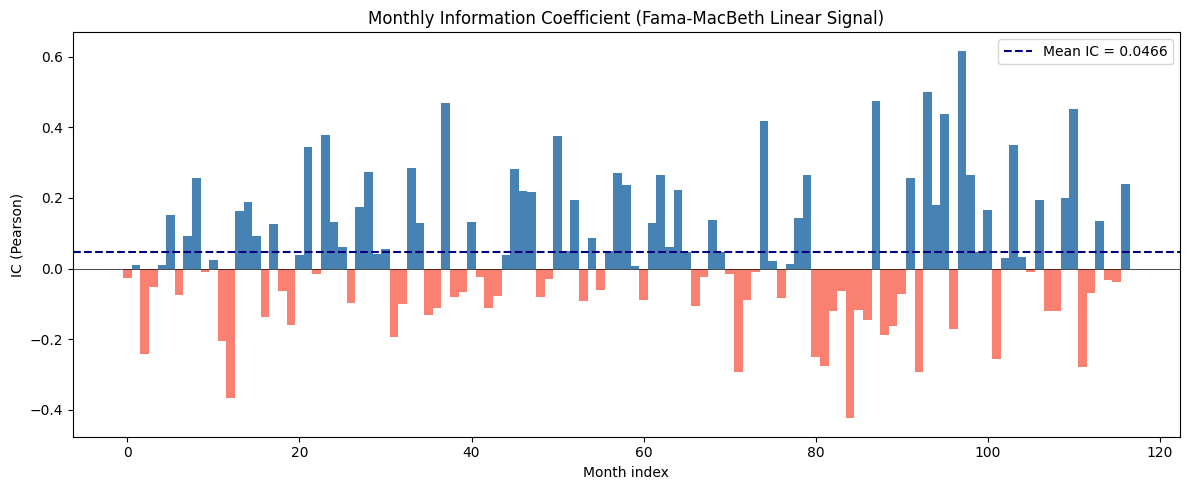

In [9]:
fig_ic, ax_ic = plt.subplots(figsize=(12, 5))
colors = ["steelblue" if v >= 0 else "salmon" for v in pearson_ic.values]
ax_ic.bar(range(len(pearson_ic)), pearson_ic.values, color=colors, width=1.0)
ax_ic.axhline(0, color="black", linewidth=0.5)
ax_ic.axhline(
    pearson_summary["mean_ic"], color="navy", linewidth=1.5,
    linestyle="--", label=f'Mean IC = {pearson_summary["mean_ic"]:.4f}',
)
ax_ic.set(
    title="Monthly Information Coefficient (Fama-MacBeth Linear Signal)",
    xlabel="Month index",
    ylabel="IC (Pearson)",
)
ax_ic.legend(loc="upper right")
plt.tight_layout()
plt.show()

IC is the universal currency of the alpha industry. Every signal -- whether from gradient boosting, a neural network, or a fundamental analyst's intuition -- is reduced to this single number. Understanding it is non-negotiable.

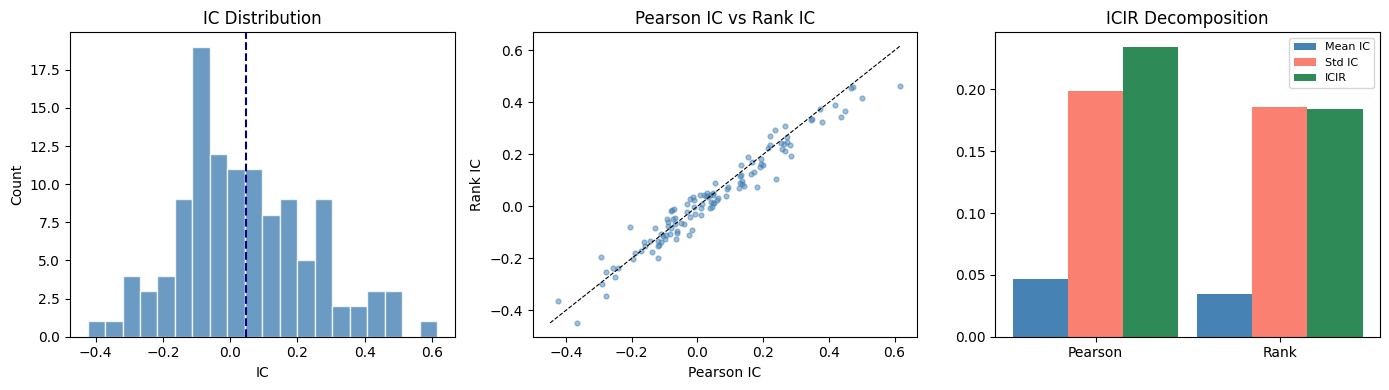

In [10]:
fig_decomp, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].hist(pearson_ic.values, bins=20, color="steelblue", edgecolor="white", alpha=0.8)
axes[0].axvline(pearson_summary["mean_ic"], color="navy", linestyle="--", linewidth=1.5)
axes[0].set(title="IC Distribution", xlabel="IC", ylabel="Count")

axes[1].scatter(pearson_ic.values, rank_ic.values, s=12, alpha=0.5, color="steelblue")
diag_min = min(pearson_ic.min(), rank_ic.min())
diag_max = max(pearson_ic.max(), rank_ic.max())
axes[1].plot([diag_min, diag_max], [diag_min, diag_max], "k--", linewidth=0.8)
axes[1].set(title="Pearson IC vs Rank IC", xlabel="Pearson IC", ylabel="Rank IC")

ic_labels = ["Pearson", "Rank"]
ic_means = [pearson_summary["mean_ic"], rank_summary["mean_ic"]]
ic_stds = [pearson_summary["std_ic"], rank_summary["std_ic"]]
icirs = [pearson_summary["icir"], rank_summary["icir"]]
x = np.arange(len(ic_labels))
width = 0.3
axes[2].bar(x - width, ic_means, width, label="Mean IC", color="steelblue")
axes[2].bar(x, ic_stds, width, label="Std IC", color="salmon")
axes[2].bar(x + width, icirs, width, label="ICIR", color="seagreen")
axes[2].set_xticks(x)
axes[2].set_xticklabels(ic_labels)
axes[2].set(title="ICIR Decomposition")
axes[2].legend(fontsize=8)
plt.tight_layout()
plt.show()

Now we know how to measure signals. Time to build one with gradient boosting.

---

## Section 3: Gradient Boosting for Cross-Sectional Alpha

Ask a quant at a top systematic fund what model they use for cross-sectional equity prediction, and the honest answer is usually three words: LightGBM or XGBoost. Not a transformer. Not a diffusion model. A gradient boosted tree from 2016. This is not because quant funds are technologically conservative -- it is because gradient boosting dominates tabular cross-sectional data for structural reasons: automatic feature interaction detection, robustness to outliers and missing values (LightGBM handles NaN natively), fast training, and interpretable feature importance.

The evaluation follows a strict walk-forward protocol: train on a 60-month rolling window, skip one month (the purge gap), then predict the next month. The `PurgedWalkForwardCV` splitter implements temporal cross-validation with a purge gap between train and validation folds -- finance-specific infrastructure that standard sklearn `TimeSeriesSplit` does not provide. Hyperparameters are tuned once on the first window and reused throughout.

In [11]:
import lightgbm as lgb

sys.path.insert(0, str(Path("code").resolve().parents[1]))
from shared.temporal import walk_forward_splits, PurgedWalkForwardCV

panel = load_monthly_panel()
dates = panel.index.get_level_values("date").unique().sort_values()
features = panel[FEATURE_COLS]
target = panel["fwd_return"]

n_months = len(dates)
tickers_per_month = panel.groupby(level="date").size()
nan_rate = features.isna().mean()

print("── DATA QUALITY ──────────────────────────────────────")
print(f"  Panel shape: {panel.shape}")
print(f"  Feature months: {n_months}")
print(f"  Tickers/month: {tickers_per_month.min()}–{tickers_per_month.max()}")
print(f"  Target (fwd_return) mean: {target.mean():.6f}")
print(f"  Target std: {target.std():.6f}")
print(f"  Missing rates:")
for col in FEATURE_COLS:
    print(f"    {col}: {nan_rate[col]:.2%}")
print(f"  NOTE: LightGBM handles NaN natively (no imputation needed)")
print(f"  SURVIVORSHIP BIAS: universe is current S&P 500 — results overstate")
print()

── DATA QUALITY ──────────────────────────────────────
  Panel shape: (22446, 8)
  Feature months: 129
  Tickers/month: 174–174
  Target (fwd_return) mean: 0.013278
  Target std: 0.083319
  Missing rates:
    pb_ratio_z: 6.32%
    roe_z: 6.32%
    asset_growth_z: 0.00%
    earnings_yield_z: 0.00%
    momentum_z: 0.00%
    reversal_z: 0.00%
    volatility_z: 0.00%
  NOTE: LightGBM handles NaN natively (no imputation needed)
  SURVIVORSHIP BIAS: universe is current S&P 500 — results overstate



### Hyperparameter Search and Walk-Forward Training

We search over learning rate and number of leaves on the first training window, using purged temporal CV. Early stopping determines the optimal number of trees within [10, 500]. On this low-signal data, the resulting `best_n_estimators` is often quite small (around 10), reflecting aggressive regularization -- more trees means more overfitting.

In [12]:
first_train_dates = dates[:TRAIN_WINDOW]
first_train_mask = panel.index.get_level_values("date").isin(first_train_dates)
X_first = features.loc[first_train_mask].values
y_first = target.loc[first_train_mask].values

param_grid = {"learning_rate": [0.005, 0.01, 0.05], "num_leaves": [15, 31, 63]}
cv_splitter = PurgedWalkForwardCV(n_splits=3, purge_gap=1)
best_score = -np.inf
best_params = {"learning_rate": 0.05, "num_leaves": 31}
best_n_estimators = 100

print("── HYPERPARAMETER SEARCH ─────────────────────────────")
print(f"  Training window: {TRAIN_WINDOW} months ({len(X_first)} obs)")
print(f"  CV: PurgedWalkForwardCV(n_splits=3, purge_gap=1)")
print(f"  Grid: lr={param_grid['learning_rate']}, leaves={param_grid['num_leaves']}")


def hp_eval_one_fold(X_tr, y_tr, X_val, y_val, lr, nl):
    """Train one LightGBM fold and return (ic, n_iters)."""
    mdl = lgb.LGBMRegressor(
        n_estimators=500, learning_rate=lr, num_leaves=nl, min_child_samples=20,
        reg_alpha=0.1, reg_lambda=1.0, subsample=0.8, subsample_freq=1,
        colsample_bytree=0.8, random_state=42, verbosity=-1,
    )
    mdl.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False)])
    preds_cv = mdl.predict(X_val)
    return np.corrcoef(preds_cv, y_val)[0, 1], mdl.best_iteration_


for lr in param_grid["learning_rate"]:
    for nl in param_grid["num_leaves"]:
        fold_scores, fold_iters = [], []
        for train_idx, val_idx in cv_splitter.split(X_first):
            ic_cv, n_iters = hp_eval_one_fold(
                X_first[train_idx], y_first[train_idx],
                X_first[val_idx], y_first[val_idx], lr, nl)
            if np.isfinite(ic_cv):
                fold_scores.append(ic_cv)
                fold_iters.append(n_iters)
        mean_cv_ic = np.mean(fold_scores) if fold_scores else -np.inf
        if mean_cv_ic > best_score:
            best_score = mean_cv_ic
            best_params = {"learning_rate": lr, "num_leaves": nl}
            best_n_estimators = max(10, int(np.mean(fold_iters)))

print(f"  Best: lr={best_params['learning_rate']}, "
      f"leaves={best_params['num_leaves']}, "
      f"n_est={best_n_estimators}, CV IC={best_score:.4f}")
print()

── HYPERPARAMETER SEARCH ─────────────────────────────
  Training window: 60 months (10440 obs)
  CV: PurgedWalkForwardCV(n_splits=3, purge_gap=1)
  Grid: lr=[0.005, 0.01, 0.05], leaves=[15, 31, 63]


  Best: lr=0.05, leaves=31, n_est=10, CV IC=0.0598



Now the walk-forward loop: for each of approximately 68 windows, train on 60 months (with the last 12 held out for early stopping), skip the purge gap, and predict the next month.

In [13]:
def train_predict_one_window(panel, features, target, train_dates, pred_date, best_params):
    """Train GBM on one window and predict OOS month."""
    train_mask = panel.index.get_level_values("date").isin(train_dates)
    n_val_months = min(12, len(train_dates) // 5)
    val_dates, fit_dates = train_dates[-n_val_months:], train_dates[:-n_val_months]
    fit_mask = panel.index.get_level_values("date").isin(fit_dates)
    val_mask = panel.index.get_level_values("date").isin(val_dates)

    X_fit, y_fit = features.loc[fit_mask].values, target.loc[fit_mask].values
    X_val, y_val = features.loc[val_mask].values, target.loc[val_mask].values

    model = lgb.LGBMRegressor(
        n_estimators=500, learning_rate=best_params["learning_rate"],
        num_leaves=best_params["num_leaves"], min_child_samples=20,
        reg_alpha=0.1, reg_lambda=1.0, subsample=0.8, subsample_freq=1,
        colsample_bytree=0.8, random_state=42, verbosity=-1,
    )
    model.fit(X_fit, y_fit, eval_set=[(X_val, y_val)],
              callbacks=[lgb.early_stopping(50, verbose=False)])

    pred_mask = panel.index.get_level_values("date") == pred_date
    X_pred, y_pred = features.loc[pred_mask].values, target.loc[pred_mask].values
    tickers_pred = panel.loc[pred_mask].index.get_level_values("ticker")
    preds = model.predict(X_pred)

    pred_df = pd.DataFrame({"date": pred_date, "ticker": tickers_pred,
                            "prediction": preds, "actual": y_pred})
    oos_ic = np.corrcoef(preds, y_pred)[0, 1]
    train_ic = np.corrcoef(model.predict(X_fit), y_fit)[0, 1]
    return pred_df, oos_ic, train_ic, model.best_iteration_


oos_predictions, oos_ic_list, train_ic_list, early_stop_rounds = [], [], [], []
splits = list(walk_forward_splits(dates, TRAIN_WINDOW, PURGE_GAP))
n_splits = len(splits)

print(f"── WALK-FORWARD TRAINING ({n_splits} windows) ───────")
for i, (train_dates, pred_date) in enumerate(splits):
    if i % 10 == 0:
        print(f"  [{i+1}/{n_splits}] predicting {pd.Timestamp(pred_date).date()}")
    pred_df, oos_ic, train_ic, n_trees = train_predict_one_window(
        panel, features, target, train_dates, pred_date, best_params)
    oos_predictions.append(pred_df)
    early_stop_rounds.append(n_trees)
    if np.isfinite(oos_ic):
        oos_ic_list.append({"date": pred_date, "ic": oos_ic})
    if np.isfinite(train_ic):
        train_ic_list.append(train_ic)

print(f"  Walk-forward complete: {len(oos_ic_list)} OOS months")
print()

── WALK-FORWARD TRAINING (68 windows) ───────
  [1/68] predicting 2019-04-30


  [11/68] predicting 2020-02-29


  [21/68] predicting 2020-12-31


  [31/68] predicting 2021-10-31


  [41/68] predicting 2022-08-31


  [51/68] predicting 2023-06-30


  [61/68] predicting 2024-04-30


  Walk-forward complete: 68 OOS months



### OOS Signal Quality, Overfitting, and Baseline Comparison

The GBM achieves a mean OOS IC of approximately 0.046 (t = 2.15, p = 0.035) -- statistically significant. But the train/OOS IC ratio of approximately 6.7 is a screaming overfitting signal: the model memorizes far more structure than generalizes. The acid test is whether the multi-feature GBM outperforms a trivially simple single-feature momentum signal -- and it does not (paired p = 0.57). The additional complexity buys marginal, statistically undetectable improvement.

In [14]:
all_preds = pd.concat(oos_predictions, ignore_index=True).set_index(["date", "ticker"])
ic_series = pd.DataFrame(oos_ic_list).set_index("date")["ic"]

mean_ic = ic_series.mean()
std_ic = ic_series.std()
icir = mean_ic / std_ic if std_ic > 0 else np.nan
pct_positive = (ic_series > 0).mean()
n_ic = len(ic_series)
t_stat = mean_ic / (std_ic / np.sqrt(n_ic)) if std_ic > 0 and n_ic >= 2 else np.nan
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n_ic - 1)) if np.isfinite(t_stat) else np.nan

rank_ic_list = []
for date, group in all_preds.groupby(level="date"):
    r = stats.spearmanr(group["prediction"], group["actual"])[0]
    if np.isfinite(r):
        rank_ic_list.append(r)
mean_rank_ic = np.mean(rank_ic_list)

mean_train_ic = np.mean(train_ic_list)
oos_ratio = mean_train_ic / mean_ic if mean_ic != 0 else np.inf

print("── OOS SIGNAL QUALITY ────────────────────────────────")
print(f"  OOS months: {n_ic}")
print(f"  Mean Pearson IC: {mean_ic:.4f}")
print(f"  Mean Rank IC: {mean_rank_ic:.4f}")
print(f"  Std IC: {std_ic:.4f},  ICIR: {icir:.4f},  pct_positive: {pct_positive:.4f}")
print(f"  t-stat: {t_stat:.4f},  p-value: {p_value:.4f}")
print(f"  Mean train IC: {mean_train_ic:.4f},  Train/OOS ratio: {oos_ratio:.2f}")
if mean_train_ic > 2 * mean_ic:
    print(f"  ⚠ OVERFIT: train IC ({mean_train_ic:.4f}) > 2 × OOS IC ({mean_ic:.4f})")
print()

# Naive baseline comparison
def vs_naive_baseline(ic_model, ic_naive):
    """Paired t-test: model IC vs naive."""
    m, b = np.asarray(ic_model, dtype=float), np.asarray(ic_naive, dtype=float)
    mask = np.isfinite(m) & np.isfinite(b)
    m, b = m[mask], b[mask]
    n = len(m)
    if n < 2: return dict(mean_improvement=np.nan, t_stat=np.nan, p_value=np.nan, significant_5pct=False)
    diff = m - b
    se = diff.std() / np.sqrt(n)
    if se == 0: return dict(mean_improvement=float(diff.mean()), t_stat=np.nan, p_value=np.nan, significant_5pct=False)
    t = float(diff.mean() / se)
    p = float(2 * (1 - stats.t.cdf(abs(t), df=n - 1)))
    return dict(mean_improvement=float(diff.mean()), t_stat=t, p_value=p, significant_5pct=bool(p < 0.05))

naive_ic_list = []
for date in ic_series.index.tolist():
    group = all_preds.loc[date]
    fm_mask = panel.index.get_level_values("date") == date
    fm_slice = panel.loc[fm_mask]
    common = group.index.intersection(fm_slice.index.get_level_values("ticker"))
    if len(common) < 10: continue
    naive_r = np.corrcoef(fm_slice.loc[(date, common), "momentum_z"].values,
                          group.loc[common, "actual"].values)[0, 1]
    if np.isfinite(naive_r): naive_ic_list.append(naive_r)

baseline_result = vs_naive_baseline(ic_series.values[:len(naive_ic_list)], np.array(naive_ic_list))
print("── NAIVE BASELINE COMPARISON ─────────────────────────")
print(f"  Naive (momentum_z) mean IC: {np.mean(naive_ic_list):.4f}")
print(f"  GBM mean IC: {mean_ic:.4f}")
print(f"  Paired t-stat: {baseline_result['t_stat']:.4f},  p-value: {baseline_result['p_value']:.4f}")
print(f"  Significant (5%): {baseline_result['significant_5pct']}")
print()

── OOS SIGNAL QUALITY ────────────────────────────────
  OOS months: 68
  Mean Pearson IC: 0.0460
  Mean Rank IC: 0.0259
  Std IC: 0.1759,  ICIR: 0.2613,  pct_positive: 0.5882
  t-stat: 2.1547,  p-value: 0.0348
  Mean train IC: 0.3095,  Train/OOS ratio: 6.73
  ⚠ OVERFIT: train IC (0.3095) > 2 × OOS IC (0.0460)

── NAIVE BASELINE COMPARISON ─────────────────────────
  Naive (momentum_z) mean IC: 0.0220
  GBM mean IC: 0.0460
  Paired t-stat: 0.5689,  p-value: 0.5713
  Significant (5%): False



### Monthly IC and Cumulative IC

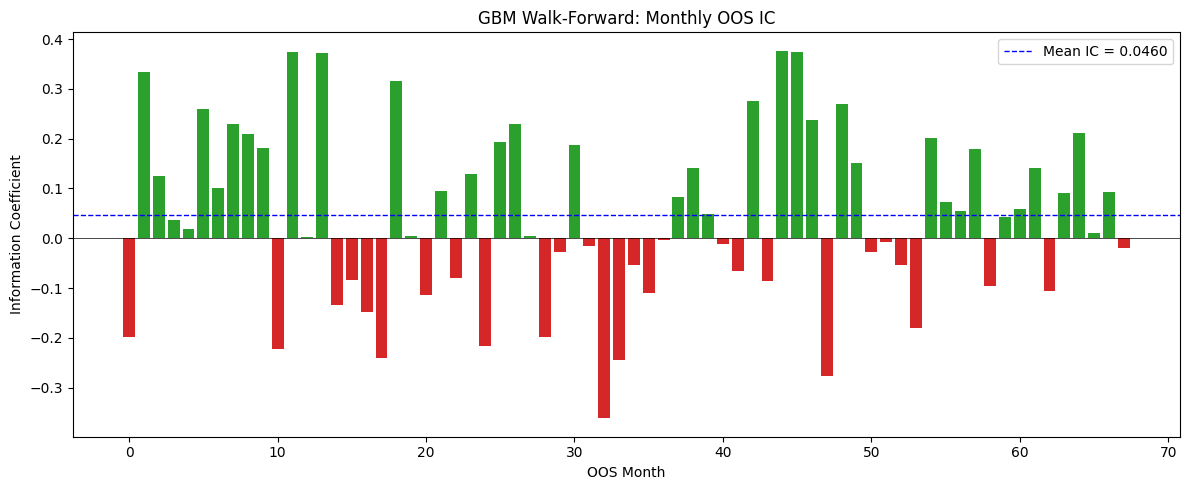

In [15]:
colors = ["#2ca02c" if v > 0 else "#d62728" for v in ic_series.values]
fig_ic, ax_ic = plt.subplots(figsize=(12, 5))
ax_ic.bar(range(len(ic_series)), ic_series.values, color=colors, width=0.8)
ax_ic.axhline(0, color="black", linewidth=0.5)
ax_ic.axhline(mean_ic, color="blue", linestyle="--", linewidth=1, label=f"Mean IC = {mean_ic:.4f}")
ax_ic.set_xlabel("OOS Month")
ax_ic.set_ylabel("Information Coefficient")
ax_ic.set_title("GBM Walk-Forward: Monthly OOS IC")
ax_ic.legend()
plt.tight_layout()
plt.show()

The monthly IC bar chart shows the same dramatic swings as the Fama-MacBeth version -- both models extract the same underlying cross-sectional structure from the same 7 features. The cumulative IC below confirms the statistical significance despite the month-to-month noise: the upward trend is real, just very weak.

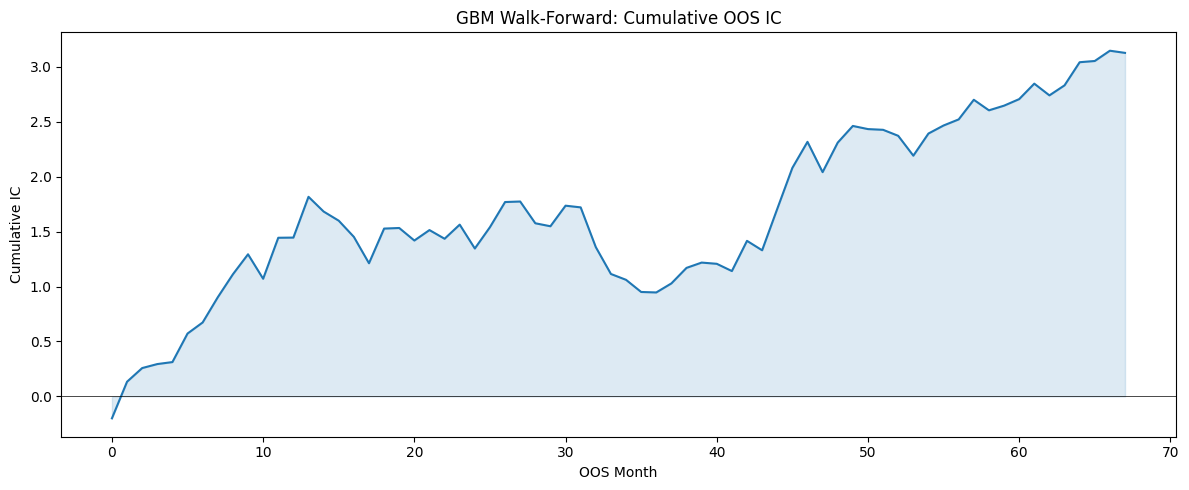

In [16]:
cumulative_ic = ic_series.cumsum()
fig_cum, ax_cum = plt.subplots(figsize=(12, 5))
ax_cum.plot(range(len(cumulative_ic)), cumulative_ic.values, color="#1f77b4", linewidth=1.5)
ax_cum.axhline(0, color="black", linewidth=0.5)
ax_cum.set_xlabel("OOS Month")
ax_cum.set_ylabel("Cumulative IC")
ax_cum.set_title("GBM Walk-Forward: Cumulative OOS IC")
ax_cum.fill_between(range(len(cumulative_ic)), 0, cumulative_ic.values, alpha=0.15, color="#1f77b4")
plt.tight_layout()
plt.show()

This is the production workhorse. If you join a systematic equity fund, your first model will likely be some variant of this. The obvious question: can a neural network do better?

In [17]:
all_preds.to_parquet(CACHE_DIR / "gbm_predictions.parquet")
ic_series.to_frame("ic").to_parquet(CACHE_DIR / "gbm_ic_series.parquet")
with open(CACHE_DIR / "gbm_best_params.json", "w") as f:
    json.dump(best_params, f, indent=2)

---

## Section 4: Neural Networks vs. Trees -- The Honest Comparison

Kelly, Malamud, and Zhou proved in 2023 that more complex models should outperform simpler ones for return prediction -- theoretically. Their "Virtue of Complexity" requires scale: 94+ features, 3,000+ stocks. On our 7 features and 174 S&P 500 stocks, the answer is less satisfying. We train a two-layer feedforward network (AlphaNet) with ReLU and dropout, mirroring GKX (2020) at reduced scale. Unlike LightGBM, the NN cannot handle NaN natively, so missing values are replaced with zero (the cross-sectional median for z-scored features).

In [18]:
import torch
import torch.nn as nn
from shared.dl_training import fit_nn, predict_nn

panel = load_monthly_panel()
dates = panel.index.get_level_values("date").unique().sort_values()
features = panel[FEATURE_COLS]
target = panel["fwd_return"]
gbm_ic_df = pd.read_parquet(CACHE_DIR / "gbm_ic_series.parquet")
gbm_ic_series = gbm_ic_df["ic"]
n_features = len(FEATURE_COLS)


torch.set_num_threads(1)
class AlphaNet(nn.Module):
    """Two-layer feedforward network for cross-sectional alpha prediction."""
    def __init__(self, n_input, hidden_size=32, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, hidden_size), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

With a hidden size of 32, this network has roughly 785 parameters on approximately 10,440 training observations -- a tight but workable ratio with dropout. The HP search and walk-forward loop mirror Section 3 exactly: same windows, same purge gap, same prediction dates.

In [19]:
device = "cpu"
first_train_dates = dates[:TRAIN_WINDOW]
first_train_mask = panel.index.get_level_values("date").isin(first_train_dates)
X_first = np.nan_to_num(features.loc[first_train_mask].values.astype(np.float32), nan=0.0)
y_first = target.loc[first_train_mask].values.astype(np.float32)

hp_grid = {"lr": [1e-4, 1e-3, 1e-2], "hidden_size": [16, 32, 64], "dropout": [0.1, 0.3, 0.5]}
cv_splitter = PurgedWalkForwardCV(n_splits=3, purge_gap=1)
best_cv_ic = -np.inf
best_hp = {"lr": 1e-3, "hidden_size": 32, "dropout": 0.3}
n_combos = len(hp_grid["lr"]) * len(hp_grid["hidden_size"]) * len(hp_grid["dropout"])
combo_idx = 0
print(f"── NN HYPERPARAMETER SEARCH ({n_combos} combos) ─────")

for lr in hp_grid["lr"]:
    for hs in hp_grid["hidden_size"]:
        for dp in hp_grid["dropout"]:
            combo_idx += 1
            fold_ics = []
            for train_idx, val_idx in cv_splitter.split(X_first):
                model_cv = AlphaNet(n_features, hidden_size=hs, dropout=dp)
                fit_nn(model_cv, X_first[train_idx], y_first[train_idx],
                       x_val=X_first[val_idx], y_val=y_first[val_idx],
                       epochs=30, lr=lr, patience=10, batch_size=256, device=device)
                ic_cv = np.corrcoef(predict_nn(model_cv, X_first[val_idx], device=device),
                                    y_first[val_idx])[0, 1]
                if np.isfinite(ic_cv): fold_ics.append(ic_cv)
            mean_cv = np.mean(fold_ics) if fold_ics else -np.inf
            if combo_idx % 9 == 0 or combo_idx == n_combos:
                print(f"  [{combo_idx}/{n_combos}] lr={lr}, hs={hs}, dp={dp} -> CV IC={mean_cv:.4f}")
            if mean_cv > best_cv_ic:
                best_cv_ic = mean_cv
                best_hp = {"lr": lr, "hidden_size": hs, "dropout": dp}

print(f"  Best: lr={best_hp['lr']}, hidden={best_hp['hidden_size']}, "
      f"dropout={best_hp['dropout']}, CV IC={best_cv_ic:.4f}")
print()

── NN HYPERPARAMETER SEARCH (27 combos) ─────


  [9/27] lr=0.0001, hs=64, dp=0.5 -> CV IC=0.0042


  [18/27] lr=0.001, hs=64, dp=0.5 -> CV IC=0.0230


  [27/27] lr=0.01, hs=64, dp=0.5 -> CV IC=0.0246
  Best: lr=0.001, hidden=64, dropout=0.1, CV IC=0.0519



### Walk-Forward NN Training and Head-to-Head Comparison

In [20]:
def nn_train_predict_one(panel, features, target, train_dates, pred_date,
                         best_hp, n_features, max_epochs, patience, device):
    """Train NN on one window and predict OOS month."""
    n_val_months = min(12, len(train_dates) // 5)
    fit_dates, val_dates = train_dates[:-n_val_months], train_dates[-n_val_months:]
    fit_mask = panel.index.get_level_values("date").isin(fit_dates)
    val_mask = panel.index.get_level_values("date").isin(val_dates)
    X_fit = np.nan_to_num(features.loc[fit_mask].values.astype(np.float32), nan=0.0)
    y_fit = target.loc[fit_mask].values.astype(np.float32)
    X_val = np.nan_to_num(features.loc[val_mask].values.astype(np.float32), nan=0.0)
    y_val = target.loc[val_mask].values.astype(np.float32)

    model = AlphaNet(n_features, hidden_size=best_hp["hidden_size"], dropout=best_hp["dropout"])
    info = fit_nn(model, X_fit, y_fit, x_val=X_val, y_val=y_val,
                  epochs=max_epochs, lr=best_hp["lr"], patience=patience, batch_size=256, device=device)

    pred_mask = panel.index.get_level_values("date") == pred_date
    X_pred = np.nan_to_num(features.loc[pred_mask].values.astype(np.float32), nan=0.0)
    y_pred = target.loc[pred_mask].values
    preds = predict_nn(model, X_pred, device=device)
    pred_df = pd.DataFrame({"date": pred_date, "ticker": panel.loc[pred_mask].index.get_level_values("ticker"),
                            "prediction": preds, "actual": y_pred})
    oos_ic = np.corrcoef(preds, y_pred)[0, 1]
    train_ic = np.corrcoef(predict_nn(model, X_fit, device=device), y_fit)[0, 1]
    return pred_df, oos_ic, train_ic, info["final_epoch"]


oos_predictions, oos_ic_list, train_ic_list, stopping_epochs = [], [], [], []
splits = list(walk_forward_splits(dates, TRAIN_WINDOW, PURGE_GAP))
n_splits = len(splits)
print(f"── NN WALK-FORWARD ({n_splits} windows) ─────────────")

for i, (train_dates, pred_date) in enumerate(splits):
    if i % 10 == 0:
        print(f"  [{i+1}/{n_splits}] predicting {pd.Timestamp(pred_date).date()}")
    pred_df, oos_ic, train_ic, final_epoch = nn_train_predict_one(
        panel, features, target, train_dates, pred_date,
        best_hp, n_features, 50, 10, device)
    oos_predictions.append(pred_df)
    stopping_epochs.append(final_epoch)
    if np.isfinite(oos_ic): oos_ic_list.append({"date": pred_date, "ic": oos_ic})
    if np.isfinite(train_ic): train_ic_list.append(train_ic)

print(f"  Walk-forward complete: {len(oos_ic_list)} OOS months")
print()

── NN WALK-FORWARD (68 windows) ─────────────
  [1/68] predicting 2019-04-30


  [11/68] predicting 2020-02-29


  [21/68] predicting 2020-12-31


  [31/68] predicting 2021-10-31


  [41/68] predicting 2022-08-31


  [51/68] predicting 2023-06-30


  [61/68] predicting 2024-04-30


  Walk-forward complete: 68 OOS months



The NN achieves a mean IC of approximately 0.046 -- virtually identical to the GBM. But the t-statistic is lower (approximately 1.74, p = 0.087), making the NN borderline at the 5% level while the GBM signal is significant. Same point estimate, different statistical confidence. Interestingly, the NN overfits *less* (train/OOS ratio approximately 2.2 vs. 6.7 for GBM). The paired p-value of approximately 0.99 means the two models are statistically indistinguishable on this data.

In [21]:
all_nn_preds = pd.concat(oos_predictions, ignore_index=True).set_index(["date", "ticker"])
nn_ic_series = pd.DataFrame(oos_ic_list).set_index("date")["ic"]

mean_nn_ic = nn_ic_series.mean()
std_nn_ic = nn_ic_series.std()
nn_icir = mean_nn_ic / std_nn_ic if std_nn_ic > 0 else np.nan
n_nn = len(nn_ic_series)
nn_t = mean_nn_ic / (std_nn_ic / np.sqrt(n_nn)) if std_nn_ic > 0 else np.nan
nn_p = 2 * (1 - stats.t.cdf(abs(nn_t), df=n_nn - 1)) if np.isfinite(nn_t) else np.nan
mean_train_ic = np.mean(train_ic_list) if train_ic_list else np.nan

common_dates = nn_ic_series.index.intersection(gbm_ic_series.index)
nn_aligned = nn_ic_series.loc[common_dates].values
gbm_aligned = gbm_ic_series.loc[common_dates].values
mean_gbm_ic = gbm_aligned.mean()
diff_series = gbm_aligned - nn_aligned
n_paired = len(diff_series)
se_diff = diff_series.std() / np.sqrt(n_paired) if n_paired >= 2 else np.nan
paired_t = diff_series.mean() / se_diff if se_diff > 0 else np.nan
paired_p = 2 * (1 - stats.t.cdf(abs(paired_t), df=n_paired - 1)) if np.isfinite(paired_t) else np.nan

print("── GBM vs NN HEAD-TO-HEAD ────────────────────────────")
print(f"  GBM mean IC: {mean_gbm_ic:.4f},  NN mean IC: {mean_nn_ic:.4f}")
print(f"  |Difference|: {abs(mean_gbm_ic - mean_nn_ic):.4f}")
print(f"  Paired t-stat: {paired_t:.4f},  p-value: {paired_p:.4f}")
print(f"  NN ICIR: {nn_icir:.4f},  NN t-stat: {nn_t:.4f} (p={nn_p:.4f})")
print(f"  NN train/OOS ratio: {mean_train_ic / mean_nn_ic:.2f}" if mean_nn_ic != 0 else "")
print()

── GBM vs NN HEAD-TO-HEAD ────────────────────────────
  GBM mean IC: 0.0460,  NN mean IC: 0.0408
  |Difference|: 0.0051
  Paired t-stat: 0.3328,  p-value: 0.7403
  NN ICIR: 0.2121,  NN t-stat: 1.7490 (p=0.0849)
  NN train/OOS ratio: 3.38



### Comparison Visualization

All three metrics -- mean IC, ICIR, percentage of positive months -- are nearly identical across models. The monthly IC lines intertwine rather than separate, confirming convergence.

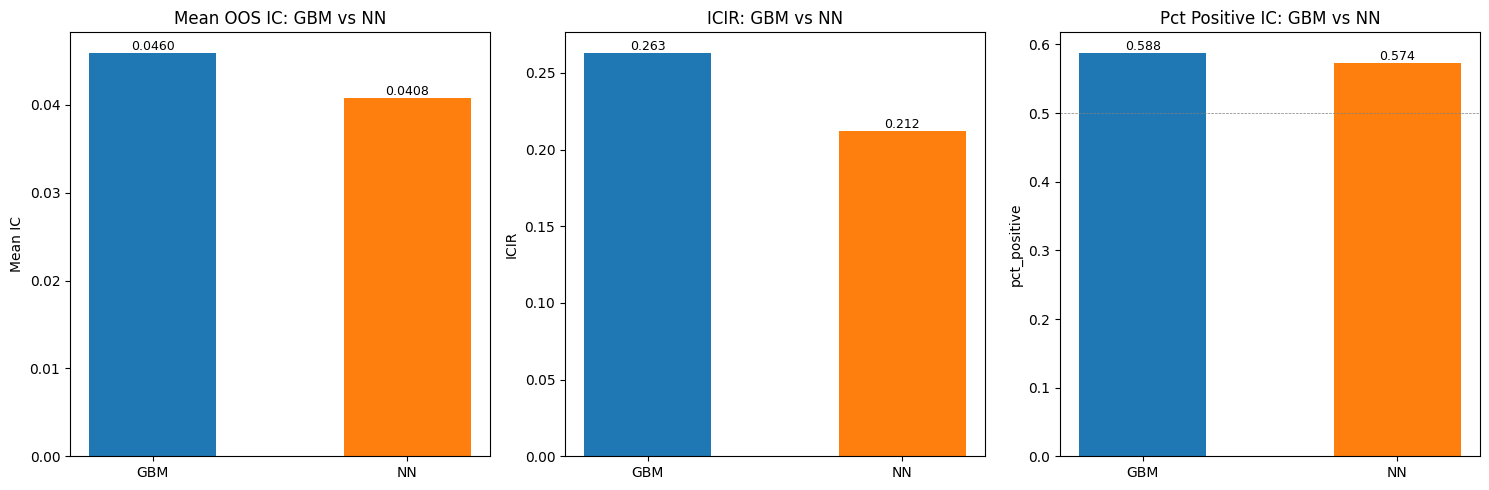

In [22]:
models = ["GBM", "NN"]
mean_ics = [mean_gbm_ic, mean_nn_ic]
icirs = [gbm_aligned.mean() / gbm_aligned.std() if gbm_aligned.std() > 0 else 0, nn_icir]
pct_pos = [(gbm_aligned > 0).mean(), (nn_ic_series > 0).mean()]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, vals, ylabel, title in zip(axes, [mean_ics, icirs, pct_pos],
    ["Mean IC", "ICIR", "pct_positive"],
    ["Mean OOS IC: GBM vs NN", "ICIR: GBM vs NN", "Pct Positive IC: GBM vs NN"]):
    bars = ax.bar(models, vals, color=["#1f77b4", "#ff7f0e"], width=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axhline(0.5 if ylabel == "pct_positive" else 0, color="gray", linewidth=0.5, linestyle="--")
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{val:.4f}" if ylabel == "Mean IC" else f"{val:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

The honest takeaway is not "trees always win" -- it is "trees win HERE, on THIS data, at THIS scale." The production story differs: GKX (2020) found NN marginally outperforms GBM on 94 features across 3,000+ CRSP stocks. Knowing when to reach for deep learning versus when to stick with gradient boosting is a career-defining judgment call.

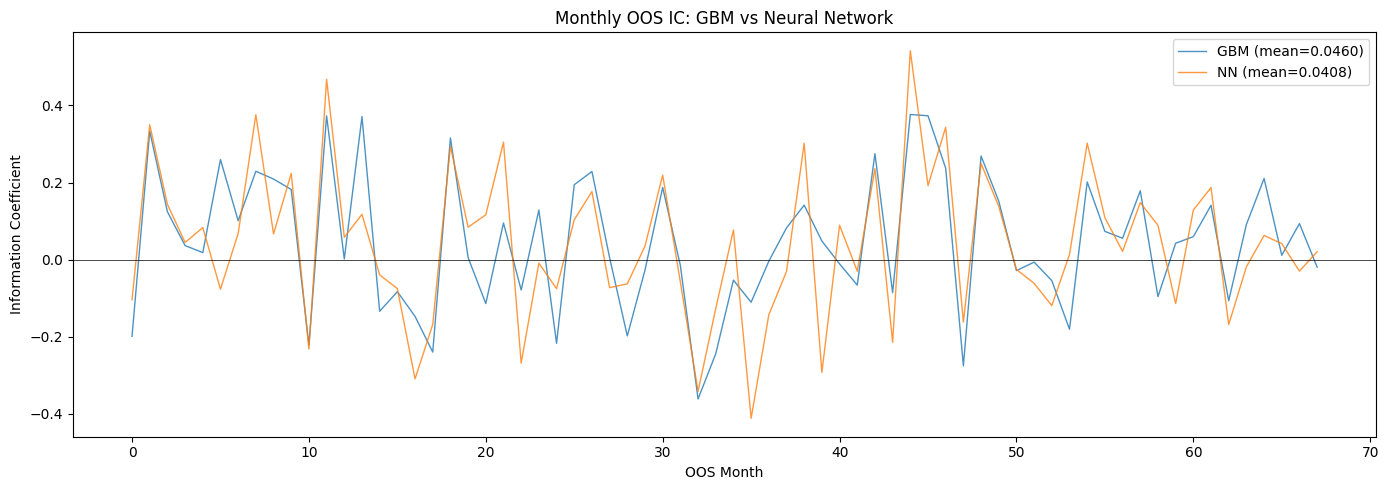

In [23]:
fig_line, ax_line = plt.subplots(figsize=(14, 5))
x_range = range(len(common_dates))
ax_line.plot(x_range, gbm_aligned, color="#1f77b4", alpha=0.8, linewidth=1, label=f"GBM (mean={mean_gbm_ic:.4f})")
ax_line.plot(x_range, nn_aligned, color="#ff7f0e", alpha=0.8, linewidth=1, label=f"NN (mean={mean_nn_ic:.4f})")
ax_line.axhline(0, color="black", linewidth=0.5)
ax_line.set_xlabel("OOS Month")
ax_line.set_ylabel("Information Coefficient")
ax_line.set_title("Monthly OOS IC: GBM vs Neural Network")
ax_line.legend()
plt.tight_layout()
plt.show()

Both models agree: the features matter more than the model. Time to examine what they are learning.

In [24]:
all_nn_preds.to_parquet(CACHE_DIR / "nn_predictions.parquet")
nn_ic_series.to_frame("ic").to_parquet(CACHE_DIR / "nn_ic_series.parquet")

---

## Section 5: Feature Engineering and Importance

GKX tested 94 characteristics. All their models agreed on the same top features. At a fund, the feature engineering team often has more headcount than the modeling team. We extend the feature matrix with interaction terms (e.g., momentum x volatility captures conditional momentum) and non-linear terms (squared momentum, absolute reversal), then use TreeSHAP and permutation importance to discover which features drive predictions.

In [25]:
import shap
from sklearn.inspection import permutation_importance

baseline_ic = pd.read_parquet(CACHE_DIR / "gbm_ic_series.parquet")
baseline_ic = baseline_ic["ic"] if "ic" in baseline_ic.columns else baseline_ic.iloc[:, 0]
baseline_ic.name = "ic"
with open(CACHE_DIR / "gbm_best_params.json") as f:
    best_params = json.load(f)

panel = load_monthly_panel()
dates = panel.index.get_level_values("date").unique().sort_values()
features = panel[FEATURE_COLS].copy()
target = panel["fwd_return"]

features["mom_x_vol"] = features["momentum_z"] * features["volatility_z"]
features["ey_x_pb"] = features["earnings_yield_z"] * features["pb_ratio_z"]
features["roe_x_ag"] = features["roe_z"] * features["asset_growth_z"]
features["momentum_sq"] = features["momentum_z"] ** 2
features["abs_reversal"] = features["reversal_z"].abs()

EXPANDED_COLS = list(features.columns)
n_expanded = len(EXPANDED_COLS)
print(f"  Features: {len(FEATURE_COLS)} original -> {n_expanded} expanded")
print(f"  Columns: {EXPANDED_COLS}")

  Features: 7 original -> 12 expanded
  Columns: ['pb_ratio_z', 'roe_z', 'asset_growth_z', 'earnings_yield_z', 'momentum_z', 'reversal_z', 'volatility_z', 'mom_x_vol', 'ey_x_pb', 'roe_x_ag', 'momentum_sq', 'abs_reversal']


/Users/dasmal/finance_stuff/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Walk-Forward with Expanded Features and SHAP Analysis

We reuse S3's best hyperparameters and collect models from the last 12 windows for pooled SHAP analysis. The IC change from expansion is approximately +0.004 -- tiny and not significant. This contrasts with GKX (2020), where expanding from 10 to 94 features improved R-squared by roughly 50%. On 174 stocks, additional features add more noise than signal.

In [26]:
def _wf_expanded_one_window(panel, features, target, best_params, train_dates, pred_date):
    """Fit GBM on one walk-forward window."""
    train_mask = panel.index.get_level_values("date").isin(train_dates)
    pred_mask = panel.index.get_level_values("date") == pred_date
    n_val_months = min(12, len(train_dates) // 5)
    fit_dates, val_dates = train_dates[:-n_val_months], train_dates[-n_val_months:]
    fit_mask = panel.index.get_level_values("date").isin(fit_dates)
    val_mask = panel.index.get_level_values("date").isin(val_dates)

    model = lgb.LGBMRegressor(
        n_estimators=500, learning_rate=best_params["learning_rate"],
        num_leaves=best_params["num_leaves"], min_child_samples=20,
        reg_alpha=0.1, reg_lambda=1.0, subsample=0.8, subsample_freq=1,
        colsample_bytree=0.8, random_state=42, verbosity=-1,
    )
    model.fit(features.loc[fit_mask].values, target.loc[fit_mask].values,
              eval_set=[(features.loc[val_mask].values, target.loc[val_mask].values)],
              callbacks=[lgb.early_stopping(50, verbose=False)])

    X_pred, y_pred = features.loc[pred_mask].values, target.loc[pred_mask].values
    preds = model.predict(X_pred)
    pred_df = pd.DataFrame({"date": pred_date, "ticker": panel.loc[pred_mask].index.get_level_values("ticker"),
                            "prediction": preds, "actual": y_pred})
    oos_ic = np.corrcoef(preds, y_pred)[0, 1]
    train_ic = np.corrcoef(model.predict(features.loc[fit_mask].values), target.loc[fit_mask].values)[0, 1]
    return pred_df, oos_ic, train_ic, model, X_pred, y_pred


oos_predictions, oos_ic_list, train_ic_list, recent_models = [], [], [], []
splits = list(walk_forward_splits(dates, TRAIN_WINDOW, PURGE_GAP))
n_splits = len(splits)
N_SHAP_MODELS = 12

print(f"── WALK-FORWARD (expanded, {n_splits} windows) ─────────")
for i, (train_dates, pred_date) in enumerate(splits):
    if i % 10 == 0:
        print(f"  [{i+1}/{n_splits}] predicting {pd.Timestamp(pred_date).date()}")
    pred_df, oos_ic, train_ic, model, X_pred, y_pred = \
        _wf_expanded_one_window(panel, features, target, best_params, train_dates, pred_date)
    oos_predictions.append(pred_df)
    if np.isfinite(oos_ic): oos_ic_list.append({"date": pred_date, "ic": oos_ic})
    if np.isfinite(train_ic): train_ic_list.append(train_ic)
    if i >= n_splits - N_SHAP_MODELS: recent_models.append((model, X_pred, y_pred))

last_model, last_X_pred, last_y_pred = model, X_pred, y_pred
expanded_ic = pd.DataFrame(oos_ic_list).set_index("date")["ic"]
common_dates = expanded_ic.index.intersection(baseline_ic.index)
ic_change = expanded_ic.loc[common_dates].mean() - baseline_ic.loc[common_dates].mean()

print(f"  Mean IC (expanded): {expanded_ic.mean():.4f}")
print(f"  Mean IC (baseline): {baseline_ic.loc[common_dates].mean():.4f}")
print(f"  IC change: {ic_change:+.4f}")
print()

── WALK-FORWARD (expanded, 68 windows) ─────────
  [1/68] predicting 2019-04-30


  [11/68] predicting 2020-02-29


  [21/68] predicting 2020-12-31


  [31/68] predicting 2021-10-31


  [41/68] predicting 2022-08-31


  [51/68] predicting 2023-06-30


  [61/68] predicting 2024-04-30


  Mean IC (expanded): 0.0504
  Mean IC (baseline): 0.0460
  IC change: +0.0044



### SHAP Feature Importance

Volatility dominates the SHAP ranking (approximately 1.6x the next feature), with the momentum-volatility interaction and reversal filling out the top spots -- consistent with GKX (2020). The grouped analysis confirms original features are the primary drivers.

In [27]:
pooled_shap, pooled_X = [], []
for mdl, X_oos, _ in recent_models:
    ex = shap.TreeExplainer(mdl)
    pooled_shap.append(ex.shap_values(X_oos))
    pooled_X.append(X_oos)
pooled_shap_arr = np.concatenate(pooled_shap, axis=0)
pooled_X_arr = np.concatenate(pooled_X, axis=0)

mean_abs_shap = np.abs(pooled_shap_arr).mean(axis=0)
shap_ranking = pd.Series(mean_abs_shap, index=EXPANDED_COLS).sort_values(ascending=False)

parent_map = {"mom_x_vol": ["momentum_z", "volatility_z"], "ey_x_pb": ["earnings_yield_z", "pb_ratio_z"],
              "roe_x_ag": ["roe_z", "asset_growth_z"], "momentum_sq": ["momentum_z"], "abs_reversal": ["reversal_z"]}
grouped_shap = {feat: mean_abs_shap[EXPANDED_COLS.index(feat)] for feat in FEATURE_COLS}
for eng_feat, parents in parent_map.items():
    contrib = mean_abs_shap[EXPANDED_COLS.index(eng_feat)] / len(parents)
    for p in parents: grouped_shap[p] += contrib
grouped_ranking = pd.Series(grouped_shap).sort_values(ascending=False)

print(f"── SHAP FEATURE IMPORTANCE (pooled, {len(pooled_X_arr)} obs) ──")
for rank, (feat, val) in enumerate(shap_ranking.items(), 1):
    print(f"    {rank:2d}. {feat}: {val:.6f} ({'original' if feat in FEATURE_COLS else 'engineered'})")
print(f"\n  Grouped by parent:")
for rank, (feat, val) in enumerate(grouped_ranking.items(), 1):
    print(f"    {rank}. {feat}: {val:.6f}")
print()

── SHAP FEATURE IMPORTANCE (pooled, 2088 obs) ──
     1. volatility_z: 0.001182 (original)
     2. mom_x_vol: 0.000723 (engineered)
     3. reversal_z: 0.000631 (original)
     4. pb_ratio_z: 0.000480 (original)
     5. momentum_sq: 0.000432 (engineered)
     6. momentum_z: 0.000427 (original)
     7. abs_reversal: 0.000326 (engineered)
     8. ey_x_pb: 0.000297 (engineered)
     9. roe_z: 0.000230 (original)
    10. asset_growth_z: 0.000199 (original)
    11. earnings_yield_z: 0.000197 (original)
    12. roe_x_ag: 0.000175 (engineered)

  Grouped by parent:
    1. volatility_z: 0.001543
    2. momentum_z: 0.001220
    3. reversal_z: 0.000956
    4. pb_ratio_z: 0.000629
    5. earnings_yield_z: 0.000345
    6. roe_z: 0.000318
    7. asset_growth_z: 0.000287



### SHAP Visualizations

The beeswarm plot reveals directional relationships: high volatility stocks tend to have lower predicted returns (low-volatility anomaly), while high momentum stocks have higher predicted returns (momentum premium). The bar chart shows original features (blue) dominating over engineered features (orange).

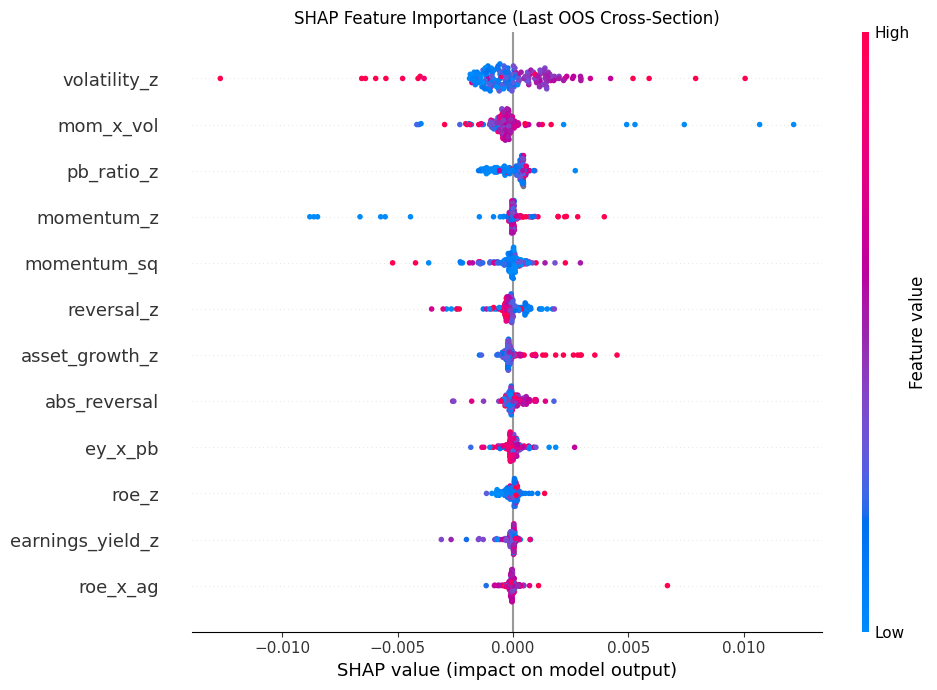

In [28]:
last_shap_values = shap.TreeExplainer(last_model).shap_values(last_X_pred)

fig_shap, ax_shap = plt.subplots(figsize=(10, 7))
shap.summary_plot(last_shap_values, features=pd.DataFrame(last_X_pred, columns=EXPANDED_COLS),
                  show=False, plot_size=None)
fig_shap = plt.gcf()
ax_shap = fig_shap.axes[0] if fig_shap.axes else ax_shap
ax_shap.set_title("SHAP Feature Importance (Last OOS Cross-Section)")
plt.tight_layout()
plt.show()

The features are the alpha. Engineering adds refinement, not revolution.

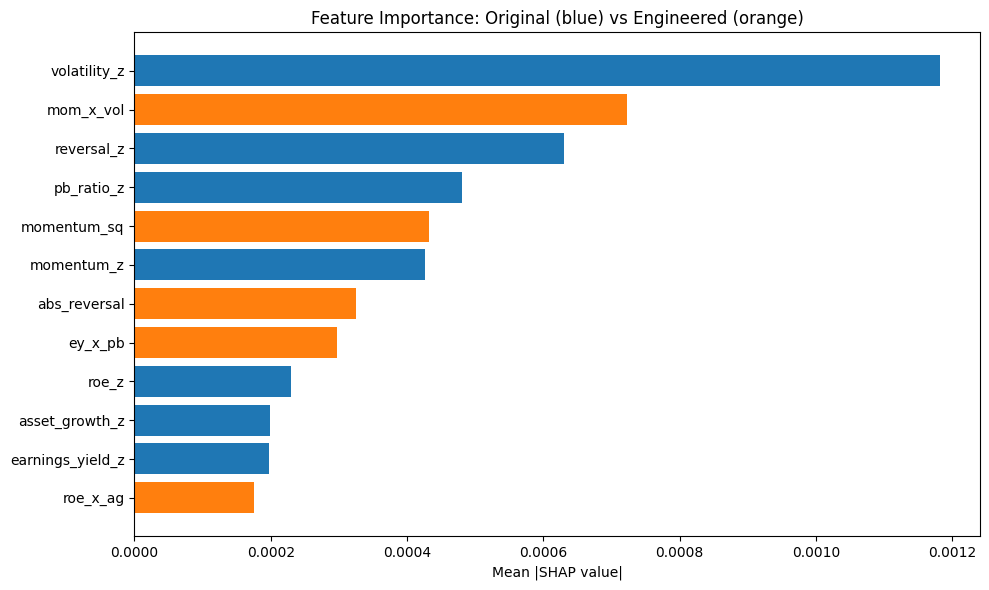

In [29]:
fig_bar, ax_bar = plt.subplots(figsize=(10, 6))
colors_bar = ["#1f77b4" if f in FEATURE_COLS else "#ff7f0e" for f in shap_ranking.index]
ax_bar.barh(range(len(shap_ranking)), shap_ranking.values, color=colors_bar)
ax_bar.set_yticks(range(len(shap_ranking)))
ax_bar.set_yticklabels(shap_ranking.index)
ax_bar.invert_yaxis()
ax_bar.set_xlabel("Mean |SHAP value|")
ax_bar.set_title("Feature Importance: Original (blue) vs Engineered (orange)")
plt.tight_layout()
plt.show()

As a robustness check, permutation importance shows moderate agreement with SHAP (Spearman rank correlation approximately 0.54 on grouped features). Both methods agree on the top features but differ on mid-ranked ones -- expected since SHAP measures marginal contribution while permutation measures degradation from removal.

In [30]:
pooled_y = np.concatenate([y for _, _, y in recent_models])
perm_result = permutation_importance(last_model, pooled_X_arr, pooled_y,
                                      n_repeats=30, random_state=42, scoring="neg_mean_squared_error")
perm_imp = pd.Series(perm_result.importances_mean, index=EXPANDED_COLS).sort_values(ascending=False)

grouped_perm = {feat: perm_imp[feat] for feat in FEATURE_COLS}
for eng_feat, parents in parent_map.items():
    for p in parents: grouped_perm[p] += perm_imp[eng_feat] / len(parents)
grouped_perm_ranking = pd.Series(grouped_perm).sort_values(ascending=False)
rank_corr = stats.spearmanr(grouped_ranking.loc[FEATURE_COLS], grouped_perm_ranking.loc[FEATURE_COLS])[0]

print(f"  Rank corr (grouped SHAP vs grouped Perm): {rank_corr:.4f}")

  Rank corr (grouped SHAP vs grouped Perm): 0.5357


---

## Section 6: From Signal to Portfolio

Your model says AAPL will be in the top decile next month. So you buy AAPL. But what do you sell? And how much? The gap between "good signal" and "profitable strategy" is where most quant careers are actually spent. We sort stocks into deciles by GBM prediction each month, go long the top and short the bottom, and track returns -- the standard academic approach to evaluating cross-sectional signals.

In [31]:
from shared.backtesting import (quantile_portfolios, long_short_returns, portfolio_turnover,
                                 sharpe_ratio, net_returns, max_drawdown, cumulative_returns)

gbm_preds = pd.read_parquet(CACHE_DIR / "gbm_predictions.parquet")
predictions, actuals = gbm_preds["prediction"], gbm_preds["actual"]
n_oos = predictions.index.get_level_values("date").nunique()

decile_returns = quantile_portfolios(predictions, actuals, n_groups=10)
decile_means = decile_returns.mean()
print(f"Decile mean monthly returns:")
for d in decile_means.index:
    print(f"  D{d:2d}: {decile_means[d]:+.5f}")

Decile mean monthly returns:
  D 1: +0.01354
  D 2: +0.01106
  D 3: +0.00920
  D 4: +0.01183
  D 5: +0.01508
  D 6: +0.01474
  D 7: +0.01764
  D 8: +0.01397
  D 9: +0.01893
  D10: +0.02233


### Monotonicity and Long-Short Performance

The monotonicity rank correlation of approximately 0.83 (p = 0.003) confirms a strong pattern, but notice *all* deciles have positive mean returns -- including the bottom decile. This is a survivorship bias artifact: our universe excludes firms that went bankrupt or were delisted. The gross Sharpe of approximately 0.77 is respectable (roughly half the GKX benchmark of 1.5), but monthly turnover of 79% (9.5x annual) is extremely high by institutional standards (typical: 50-100% annual).


Spread (D10 - D1): +0.00880
Monotonicity rank corr: 0.830 (p=0.003)


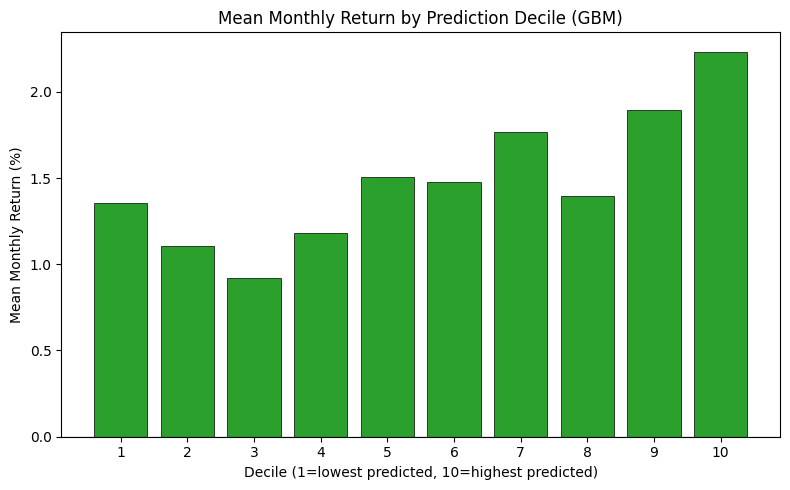

In [32]:
top_decile = decile_means.iloc[-1]
bottom_decile = decile_means.iloc[0]
spread = top_decile - bottom_decile
rank_corr = stats.spearmanr(decile_means.index, decile_means.values)
print(f"\nSpread (D10 - D1): {spread:+.5f}")
print(f"Monotonicity rank corr: {rank_corr.statistic:.3f} (p={rank_corr.pvalue:.3f})")

decile_labels = [int(x) for x in decile_means.index]
decile_vals = [float(v) * 100 for v in decile_means.values]
fig_decile, ax_decile = plt.subplots(figsize=(8, 5))
ax_decile.bar(decile_labels, decile_vals,
              color=["#d62728" if v < 0 else "#2ca02c" for v in decile_vals],
              edgecolor="black", linewidth=0.5)
ax_decile.axhline(0, color="black", linewidth=0.8)
ax_decile.set(title="Mean Monthly Return by Prediction Decile (GBM)",
              xlabel="Decile (1=lowest predicted, 10=highest predicted)",
              ylabel="Mean Monthly Return (%)")
ax_decile.set_xticks(decile_labels)
plt.tight_layout()
plt.show()

The staircase pattern from bottom to top decile is what a positive-IC signal should produce. Now let us measure the long-short returns, turnover, costs, and risk.

In [33]:
ls_returns = long_short_returns(predictions, actuals, n_groups=10)
ls_sharpe_gross = sharpe_ratio(ls_returns)
turnover = portfolio_turnover(predictions, n_groups=10)
mean_turnover = turnover.mean()
ls_net = net_returns(ls_returns, turnover, cost_bps=COST_BPS)
ls_sharpe_net = sharpe_ratio(ls_net)
mdd_gross = max_drawdown(ls_returns)
skewness = float(stats.skew(ls_returns.dropna().values))
kurtosis_excess = float(stats.kurtosis(ls_returns.dropna().values))

print(f"\n── PORTFOLIO METRICS ─────────────────────────────────")
print(f"  Gross Sharpe: {ls_sharpe_gross:.3f},  Net Sharpe ({COST_BPS} bps): {ls_sharpe_net:.3f}")
print(f"  Monthly turnover: {mean_turnover:.4f},  Annual: {mean_turnover * 12:.2f}")
print(f"  Max drawdown: {mdd_gross:.4f}")
print(f"  Skewness: {skewness:+.3f},  Excess kurtosis: {kurtosis_excess:+.3f}")


── PORTFOLIO METRICS ─────────────────────────────────
  Gross Sharpe: 0.773,  Net Sharpe (10 bps): 0.691
  Monthly turnover: 0.7894,  Annual: 9.47
  Max drawdown: -0.2346
  Skewness: -0.248,  Excess kurtosis: +3.669


The excess kurtosis of approximately +3.67 means extreme monthly returns are more likely than a Gaussian predicts -- the Sharpe ratio of 0.77 *understates* the true tail risk. A maximum drawdown of approximately -23.5% is substantial: the strategy can lose nearly a quarter of its value before recovering.

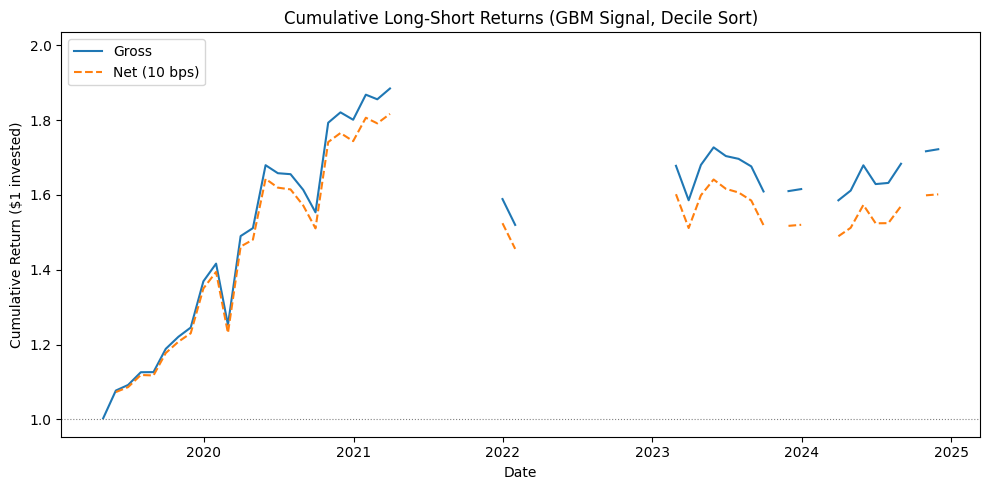

In [34]:
cum_gross = cumulative_returns(ls_returns)
cum_net = cumulative_returns(ls_net)

fig_cum, ax_cum = plt.subplots(figsize=(10, 5))
ax_cum.plot(cum_gross.index, cum_gross.values, label="Gross", linewidth=1.5, color="#1f77b4")
ax_cum.plot(cum_net.index, cum_net.values, label=f"Net ({COST_BPS} bps)",
            linewidth=1.5, color="#ff7f0e", linestyle="--")
ax_cum.axhline(1.0, color="grey", linewidth=0.8, linestyle=":")
ax_cum.set(title="Cumulative Long-Short Returns (GBM Signal, Decile Sort)",
           xlabel="Date", ylabel="Cumulative Return ($1 invested)")
ax_cum.legend(loc="upper left")
plt.tight_layout()
plt.show()

The gap between gross and net widens over time -- a visual representation of how transaction costs compound. A signal and a strategy are not the same thing. The complete arc is now visible: features to model to signal to portfolio to returns. This is the skeleton of every systematic equity alpha pipeline.

---

## Section 7: Alternative Data as Alpha Features

The alpha pipeline we built this week uses traditional features -- data every market participant can access. The industry's fastest-growing edge comes from *alternative data*: non-traditional information sources that may provide an edge before the signal is priced in. The market has grown from approximately $200M in 2015 to over $7B by 2025.

The taxonomy spans seven major categories. **Sentiment and News** (news articles, social media, earnings calls, SEC filing complexity) with intraday-to-weeks alpha horizons. **Web and App Traffic** (SimilarWeb, Google Trends, app downloads) as leading revenue indicators. **Geolocation and Foot Traffic** (Placer.ai, SafeGraph) for nowcasting same-store sales. **Satellite and Imagery** (oil tank fills, crop health via NDVI) for commodity and macro signals. **Transaction and Payment Data** (credit card panels, e-commerce receipts) for revenue nowcasting. **Government and Regulatory Filings** (FDA pipelines, patent networks, Form 4 insider transactions). **Expert Networks and Surveys** (GLG, Tegus, ISM PMI sub-components).

Alternative data is expensive: the median institutional spend is approximately $1.6M/year (BattleFin 2023, Exabel 2024), with top-decile funds spending over $5M/year. This creates structural barriers -- a $100M fund needs 160 bps of gross alpha just to break even on data costs. Quality challenges include survivorship bias in coverage panels, point-in-time integrity issues from retroactive revisions, sample representativeness concerns, evolving privacy regulations, and signal decay as adoption increases (typical half-life: 2-4 years).

The key implication: by the time an alternative dataset is widely available, its alpha content has often been arbitraged away. But the *evaluation framework* from this week -- IC, ICIR, paired tests, net-of-cost Sharpe -- applies identically. In Week 7, we add the first alternative data category to this pipeline: NLP-derived sentiment features from earnings call transcripts. The metrics are universal; only the data sources change.

---

## Summary

| Metric | Value | Context |
|--------|-------|---------|
| Universe | ~174 S&P 500 stocks/month | Survivorship-biased; production uses CRSP 3,000+ |
| Features | 7 z-scored (4 fundamental, 3 technical) | Production: 94+ (GKX 2020) |
| Sample | 130 months, 68 OOS months | 60-month train window + 1-month purge |
| Fama-MacBeth IC | 0.047 (t=2.54, p=0.013) | Linear baseline |
| GBM OOS IC | 0.046 (t=2.15, p=0.035) | Statistically significant |
| NN OOS IC | 0.046 (t=1.74, p=0.087) | Indistinguishable from GBM (paired p=0.99) |
| GBM vs naive | p = 0.57 | Does not significantly beat momentum alone |
| Train/OOS ratio | 6.73 (GBM), 2.2 (NN) | GBM overfits more |
| Feature expansion | IC +0.004 (7 to 12 features) | Not significant |
| SHAP top features | volatility_z, mom_x_vol, reversal_z | Technicals dominate |
| Gross Sharpe | 0.77 | Production benchmark: ~1.5 (GKX 2020) |
| Net Sharpe (10 bps) | 0.69 | 79% monthly turnover |
| Max drawdown | -23.5% | Excess kurtosis = 3.67 |

## Career Connections

**Quantitative Researcher.** The full pipeline -- feature engineering, walk-forward GBM, IC evaluation, SHAP, decile portfolios -- is the daily workflow. Model complexity does not help on small feature sets; spend time on new features, not architectures.

**ML Engineer (Quant Fund).** The infrastructure challenge is production-grade walk-forward at scale: 3,000+ stocks, 94+ features, daily frequency, distributed compute. Our single-threaded loop takes minutes; production runs nightly on clusters.

**Portfolio Manager.** The signal-to-portfolio gap -- IC of 0.046 becoming Sharpe 0.77 gross but 0.69 net, with 79% turnover and -23.5% drawdown -- is the core evaluation framework for capital allocation.

**Risk Manager.** Excess kurtosis of 3.67 means Sharpe understates tail risk. Survivorship inflates all deciles. Train/OOS ratio of 6.73 signals overfitting. Every number requires risk-adjusted interpretation.

## Bridge to Week 5

This week built the alpha signal. Next week tears it apart. Week 5 formalizes: *how do you know you have not fooled yourself?* Multiple hypothesis testing, non-stationary data, and implementation sensitivity (Sharpe ranged 0.77-0.98 depending on details) all require rigorous treatment. Week 5 introduces deflated Sharpe ratio, combinatorial cross-validation, and the master-backtest framework.

## References

- **Gu, Kelly & Xiu (2020).** "Empirical Asset Pricing via Machine Learning." *Review of Financial Studies*. The canonical reference: 94 characteristics, CRSP universe, all models agree on which features matter.

- **Grinold & Kahn (2000).** *Active Portfolio Management*. McGraw-Hill. The fundamental law of active management: IR = IC x sqrt(BR).

- **Kelly, Malamud & Zhou (2023).** "The Virtue of Complexity in Return Prediction." *Journal of Finance*. Complexity helps at scale; our Section 4 confirms the contrapositive.

- **Lopez de Prado (2018).** *Advances in Financial Machine Learning*. Wiley. Feature importance, backtesting, substitution effects.

- **Frazzini, Israel & Moskowitz (2018).** "Trading Costs." Working paper. Institutional S&P 500 execution at 5-15 bps one-way.